In [2]:
from langchain_mcp_adapters.client import MultiServerMCPClient
from langgraph.graph import StateGraph, MessagesState, START
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display

In [3]:
from langchain.chat_models import init_chat_model
model = init_chat_model("gemini-2.5-flash", model_provider="google_genai")

client = MultiServerMCPClient(
    {
        "mathserver": {
            "url": "http://localhost:9999/mcp",
            "transport": "streamable_http",
        }
    }
)

In [4]:
async def process():
    tools = await client.get_tools()

    def call_model(state: MessagesState):
        response = model.bind_tools(tools).invoke(state["messages"])
        return {"messages": response}

    builder = StateGraph(MessagesState)
    builder.add_node(call_model)
    builder.add_node(ToolNode(tools))
    builder.add_edge(START, "call_model")
    builder.add_conditional_edges(
        "call_model",
        tools_condition,
    )
    builder.add_edge("tools", "call_model")
    graph = builder.compile()

    display(Image(graph.get_graph().draw_mermaid_png()))

    response = await graph.ainvoke({"messages": "Is 38364323 a prime number?"})
    for message in response['messages']:
        message.pretty_print()

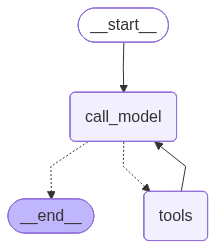

================================ Human Message =================================

Is 38364323 a prime number?
================================== Ai Message ==================================
Tool Calls:
  isPrime (8ea5c5cd-cd47-4ed9-9cb7-6cc4bbd8ae93)
 Call ID: 8ea5c5cd-cd47-4ed9-9cb7-6cc4bbd8ae93
  Args:
    num: 38364323
================================= Tool Message =================================
Name: isPrime

true
================================== Ai Message ==================================

Yes, 38364323 is a prime number.


In [5]:
await process()